# ML Pipeline Preparation

This is a helper script that serves as preparation for `train_classifier.py`.  
In this script, we use the data coming from the ETL pipeline to train and optimize a ML model that classifies any disaster messages.


## 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

Load libraries and set path to the SQL dataset.

In [1]:
import pandas as pd
import sqlalchemy as db
import re
import numpy as np
from numpy.random import default_rng

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from functions import (tokenize, evaluate_results, TextLengthExtractor, TextAugmentation)

import joblib

import matplotlib.pyplot as plt

data_base_name = '../data/DisasterResponse.db'

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\osberger\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\osberger\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\osberger\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now, create an engine that is required to read in the database.

In [2]:
engine = db.create_engine('sqlite:///' + data_base_name)
df = pd.read_sql_table('disaster_data', engine)

Let's see if the database looks as expected. For this, print out the head, categories, and genres

In [3]:
df.head()

,index,id,message,original,genre,related,request,offer,aid_related,medical_help,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
2,2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
first_category = [i for i, x in enumerate(df.columns) if x == 'related'][0]
categories = df.columns[first_category:]
genres = df.genre.unique()

print('\nCategories:\n{}'.format(list(categories)))
print('\nGenres:\n{}'.format(genres))


Categories:
['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']

Genres:
['direct' 'social' 'news']


## 2. Write a tokenization function to process your text data

The tokenizer function is part of the external `functions.py` file. Let's have a look on how it works on hands on some examples...

In [5]:
TestText = [df.message[0], df.message[3252], df.message[26178]]

for text in TestText:
    print('This is the original text:\n{}'.format(text))
    print('This is the tokenized text:\n{}\n'.format(tokenize(text)))

This is the original text:
Weather update - a cold front from Cuba that could pass over Haiti
This is the tokenized text:
['weather', 'update', 'cold', 'front', 'cuba', 'pass', 'haiti']

This is the original text:
(seemingly truncated) Port-au-Prince. We would like to help these people however possible Ok 
This is the tokenized text:
['seemingly', 'truncate', 'port', 'au', 'prince', 'like', 'help', 'people', 'however', 'possible', 'ok']

This is the original text:
Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.
This is the tokenized text:
['women', 'protest', 'conduct', 'elections', 'teargas', 'try', 'converge', 'local', 'electoral', 'commission', 'offices', 'southern', 'oil', 'city', 'port', 'harcourt']



## 3. Build machine learning pipeline

This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

#### Split the dataset to train and test dataset

For all the pipelines below, we will use the following splits to train them.
There is one experiment that tries to use the genres as features as well, so add them to the splits

In [6]:
df_genre = pd.get_dummies(df.genre, dummy_na = False, drop_first=True)
X_with_genres = pd.DataFrame(df.message).join(df_genre)
Y = df.iloc[:,5:]

# To use the splitting function, we need to use DataFrames, but convert to X_* to message.values later
X_train_with_genres, X_test_with_genres, Y_train, Y_test = train_test_split(X_with_genres, Y, test_size=0.20, random_state=8820)
X_train = X_train_with_genres.message.values
X_test = X_test_with_genres.message.values

### 3.1 Build baseline pipeline 

First, we train a first simple baseline model that can later be used to compare results of improved models.

In [14]:
pipeline = Pipeline([("vec", CountVectorizer(tokenizer=tokenize)), ("tfidf", TfidfTransformer()), ("clf", MultiOutputClassifier(RandomForestClassifier()))])

Train the baseline pipeline.

In [15]:
pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('vec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0...
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                  

Save the model to `.pkl`-file

In [16]:
joblib.dump(pipeline, 'pipeline_baseline.pkl')

['pipeline_baseline.pkl']

Test baseline pipeline.  
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

Load the model to evaluate, do the evaluation on the test dataset, and show the results.  
Before doing the whole evaluaiton, let's have a more detailed look on the first class. This may help us to understand the results in more detail.

In [7]:
pipeline_baseline = joblib.load('pipeline_baseline.pkl')
Y_pred = pipeline_baseline.predict(X_test)

# Choose some sample categories that are used for a closer look of the results
category_samples = ['related', 'water']
for i, category in enumerate(category_samples):
    cat_idx = [j for j,x in enumerate(categories) if x == category_samples[i]]
    print('\nClassification results for class {}'.format(category))
    print(classification_report(Y_test[category].to_numpy(), Y_pred[:, cat_idx], target_names=[category, "others"], labels=[1,0]))


Classification results for class related
              precision    recall  f1-score   support

     related       0.83      0.95      0.89      3985
      others       0.70      0.39      0.50      1251

    accuracy                           0.81      5236
   macro avg       0.77      0.67      0.69      5236
weighted avg       0.80      0.81      0.79      5236


Classification results for class water
              precision    recall  f1-score   support

       water       0.89      0.42      0.57       339
      others       0.96      1.00      0.98      4897

    accuracy                           0.96      5236
   macro avg       0.92      0.71      0.77      5236
weighted avg       0.96      0.96      0.95      5236



The results for `related` is fine, the one for `water` looks nice when having a look on the accuracy. However, this is misleading, because the category `water` does not have many message samples in the dataset (see the statisitcs in the ETL helper jupyter notebook). This is why most of the messages tested seem to be classified as `others`, this pushes the accuracy. The more interesting value here is the `recall`, telling us, that the category `water` has many false negatives. This shows us, that the model is bad in predicting categories that have less samples.  

Note that some warnings maybe appear since for some categories, no predictions appear.

In [8]:
df_metrics, f_metrics_mean = evaluate_results(Y_pred, Y_test, categories)

C:\Users\osberger\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\osberger\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\osberger\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Evaluation results for all categories:
                        Accuracy  Precision    Recall  F1-Score
related                 0.814744   0.832268  0.947553  0.886177
request                 0.894767   0.824762  0.485426  0.611150
offer                   0.995225   0.000000  0.000000  0.000000
aid_related             0.782468   0.760260  0.697109  0.727316
medical_help            0.927998   0.636364  0.071979  0.129330
medical_products        0.949962   0.657143  0.084249  0.149351
search_and_rescue       0.974026   0.800000  0.082759  0.150000
security                0.984148   0.000000  0.000000  0.000000
military                0.969824   0.714286  0.060976  0.112360
child_alone             1.000000   0.000000  0.000000  0.000000
water                   0.958938   0.887500  0.418879  0.569138
food                    0.943468   0.902743  0.584814  0.709804
shelter                 0.933728   0.877660  0.337423  0.487445
clothing                0.985294   0.888889  0.095238  0.172043
m

### 3.2. Pipeline using TextLengthExtractor feature

**Motivation**: It might be possible that more urgent messages are shorter than others since people that write a message in a stressed moment does not have that much time.

We defined an estimator that extracts the length of a text (number of words), see `functions.py`. Have a look on how it works... Seems to be fine :)!

In [9]:
TestTexts = ['This is my first sentence that is kind of looong', 'This is shorter']

text_len_extractor = TextLengthExtractor()
text_len_extractor.transform(TestTexts)

,0
0,10
1,3


Define and train the pipeline

In [16]:
pipeline_with_text_length = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),
        ('text_length', TextLengthExtractor())
    ])),
    ("clf", MultiOutputClassifier(RandomForestClassifier()))
])

In [18]:
pipeline_with_text_length.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
                                                                                  input='content',
                                                                                  low

Save the model

In [24]:
joblib.dump(pipeline_with_text_length, 'pipeline_with_text_length.pkl')

['pipeline_with_text_length.pkl']

Evaluate and dispay the results

In [10]:
pipeline_with_text_length = joblib.load('pipeline_with_text_length.pkl')
Y_pred = pipeline_with_text_length.predict(X_test)

df_metrics, f_metrics_mean = evaluate_results(Y_pred, Y_test, categories)

C:\Users\osberger\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\osberger\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\osberger\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Evaluation results for all categories:
                        Accuracy  Precision    Recall  F1-Score
related                 0.814171   0.823315  0.962359  0.887423
request                 0.897250   0.836502  0.493274  0.620592
offer                   0.995225   0.000000  0.000000  0.000000
aid_related             0.782850   0.752422  0.712712  0.732029
medical_help            0.927998   0.620000  0.079692  0.141230
medical_products        0.949771   0.692308  0.065934  0.120401
search_and_rescue       0.972689   0.600000  0.041379  0.077419
security                0.984339   0.000000  0.000000  0.000000
military                0.970206   0.722222  0.079268  0.142857
child_alone             1.000000   0.000000  0.000000  0.000000
water                   0.957410   0.886667  0.392330  0.543967
food                    0.944232   0.897810  0.596123  0.716505
shelter                 0.935638   0.839286  0.384458  0.527349
clothing                0.984912   0.857143  0.071429  0.131868
m

**Conclusion**: Results are slightly better.

### 3.3. Pipeline using message genres as feature

Try to add genre data as well.

**Motivation**: It could be, that some disaster categories are reported in a special way. E.g., it can be likely that `fire` disasters (a house is burning, ...) are more reported via news or directly than using social media:

In [29]:
df[df.fire == 1].genre.value_counts()

news      225
direct     41
social     16
Name: genre, dtype: int64

To do so, write a user-defined feature union that respects a list of X

In [30]:
class FeatureUnionCustom(FeatureUnion):
    def __init__(self, feature_type, transformer_list):
        self.feature_type = feature_type
        super().__init__(transformer_list)
        
    def fit(self, X, y=None):
        if (self.feature_type == 'text'):
            return super().fit(X.message.values, y)
        else:
            return super().fit(X.drop(columns=['message']), y)
        
    def transform(self, X):
        if (self.feature_type == 'text'):
            return super().transform(X.message.values)
        else:
            return super().transform(X.drop(columns=['message']))
        
    def fit_transform(self, X, y=None):
        if (self.feature_type == 'text'):
            return super().fit_transform(X.message.values, y)
        else:
            return super().fit_transform(X.drop(columns=['message']), y)
    
class IdentityFeature(BaseEstimator):
    def transform(self, X):
        return X
        
    def fit_transform(self, X, y=None, **fit_params):
        return X

Define and train the pipeline

In [31]:
pipeline_with_genre = Pipeline([
    ('features', FeatureUnion([
        ('features_text', FeatureUnionCustom('text', transformer_list = [
            ('features_text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
                ])),
            ('text_length', TextLengthExtractor())])),
         ('features_genre', FeatureUnionCustom('no_text', [('identity', IdentityFeature())]))
    ])),
    ("clf", MultiOutputClassifier(RandomForestClassifier()))
])

In [32]:
pipeline_with_genre.fit(X_train_with_genres, Y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('features_text',
                                                 FeatureUnionCustom(feature_type='text',
                                                                    transformer_list=[('features_text_pipeline',
                                                                                       Pipeline(memory=None,
                                                                                                steps=[('vect',
                                                                                                        CountVectorizer(analyzer='word',
                                                                                                                        binary=False,
                                                                                                                        decode_error='strict',
   

Save the model

In [33]:
joblib.dump(pipeline_with_genre, 'pipeline_with_genre.pkl')

['pipeline_with_genre.pkl']

Evaluate and dispay the results

In [34]:
pipeline_with_genre = joblib.load('pipeline_with_genre.pkl')
Y_pred = pipeline_with_genre.predict(X_test_with_genres)

df_metrics, f_metrics_mean = evaluate_results(Y_pred, Y_test, categories)

C:\Users\osberger\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\osberger\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\osberger\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Evaluation results for all categories:
                        Accuracy  Precision    Recall  F1-Score
related                 0.813216   0.822847  0.961606  0.886832
request                 0.900115   0.838532  0.512332  0.636047
offer                   0.995225   0.000000  0.000000  0.000000
aid_related             0.779794   0.753458  0.699862  0.725672
medical_help            0.930099   0.755556  0.087404  0.156682
medical_products        0.950726   0.682927  0.102564  0.178344
search_and_rescue       0.972498   0.538462  0.048276  0.088608
security                0.984148   0.000000  0.000000  0.000000
military                0.970588   0.750000  0.091463  0.163043
child_alone             1.000000   0.000000  0.000000  0.000000
water                   0.957219   0.896552  0.383481  0.537190
food                    0.937357   0.907563  0.523425  0.663934
shelter                 0.932200   0.828431  0.345603  0.487734
clothing                0.986440   0.933333  0.166667  0.282828
m

**Conclusion**: Adding the genres as features seem to improve the resulting model at least a bit. Unfortunately, the genres are not used as a feature in the web-app, therefore we cannot really use them.

### 3.4. Pipeline using data augmentation

As next experiment, we will use some data augmentation to improve performance.

**Motivation**: As alreads mentioned above, the messages are far away from a uniformly distribution over the categories (see plot below). This leads to poor results for many categories that are underrepresented. This inbalanced data can be improved with data augmentation.

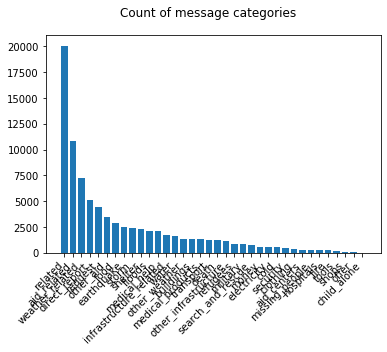

In [7]:
df_cat = df.drop(columns=['index', 'id', 'message', 'original', 'genre'])
cat_counts = df_cat.sum().sort_values(ascending=False)
cat_names = cat_counts.index
plt.bar(cat_names, cat_counts)
plt.xticks(rotation=45, ha='right')
plt.suptitle('Count of message categories')
plt.show()

In the following, use the augmentaiton class from `functions.py`. Show how the augmentation works on a single category.

In [8]:
augmentation = TextAugmentation(categories, 1000)
X_aug, Y_aug = augmentation.augment_category(X_train, Y_train, 'electricity')

# Print an example
X_aug[500]

'power power cause remain work close days days home home'

Apply the augmentation. In addition, let us remove unlabeld data, hence data that does not cotain ategory-specific information.

In [9]:
X_train = X_train[Y_train.sum(axis = 1) > 0]
Y_train = Y_train[Y_train.sum(axis = 1) > 0]

In [10]:
augmentation = TextAugmentation(categories, 3000)
X_train_aug, Y_train_aug = augmentation.augment(X_train, Y_train)

Define and train the pipeline. Unforunately, skitlearn pipelines cannot handle tansformations of X --> augment training data before "by hand".

In [43]:
pipeline_with_augmentation = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),
        ('text_length', TextLengthExtractor())
    ])),
    ("clf", MultiOutputClassifier(RandomForestClassifier()))
])

In [45]:
pipeline_with_augmentation.fit(X_train_aug, Y_train_aug)

In [46]:
joblib.dump(pipeline_with_augmentation, 'classifier.pkl')

['classifier.pkl']

In [47]:
pipeline_with_augmentation = joblib.load('classifier.pkl')
Y_pred = pipeline_with_augmentation.predict(X_test)

df_metrics, f_metrics_mean = evaluate_results(Y_pred, Y_test, categories)

C:\Users\osberger\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\osberger\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\osberger\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Evaluation results for all categories:
                        Accuracy  Precision    Recall  F1-Score
related                 0.754966   0.762127  0.985696  0.859613
request                 0.892857   0.756589  0.547085  0.635003
offer                   0.995225   0.000000  0.000000  0.000000
aid_related             0.754202   0.703097  0.708582  0.705829
medical_help            0.927426   0.554217  0.118252  0.194915
medical_products        0.952063   0.671875  0.157509  0.255193
search_and_rescue       0.973453   0.607143  0.117241  0.196532
security                0.983193   0.000000  0.000000  0.000000
military                0.971925   0.634921  0.243902  0.352423
child_alone             1.000000   0.000000  0.000000  0.000000
water                   0.956646   0.858974  0.395280  0.541414
food                    0.945378   0.850526  0.652666  0.738574
shelter                 0.936402   0.814516  0.413088  0.548168
clothing                0.985294   0.888889  0.095238  0.172043
m

**Conclusion**: There is a slightly increase of the `recall`, so augmentation should be considered for further analysis.

### 3.5 Try some other classifiers

to avoid long caluclations, we will choose a reference category (`water`) and check how other classifiers perform on it.

#### Support Vector Classifier (SVM)

Define and train the classifier for a single category.

In [100]:
from sklearn.svm import SVC

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),
        ('text_length', TextLengthExtractor())
    ])),
    ("clf", SVC(kernel = 'linear', class_weight = 'balanced'))
])

In [101]:
pipeline.fit(X_train_aug, Y_train_aug.water)
joblib.dump(pipeline, 'classifier_svm_water.pkl')

['classifier_svm_water.pkl']

Evaluate the classifier

In [103]:
pipeline = joblib.load('classifier_svm_water.pkl')
Y_pred = pipeline.predict(X_test)

df_metrics, f_metrics_mean = evaluate_results(Y_pred, Y_test.water, ['water'])

Evaluation results for all categories:
       Accuracy  Precision    Recall  F1-Score
water  0.939458   0.524123  0.705015  0.601258

Mean evaluation metrics over all categories:
           overall mean
Accuracy       0.939458
Precision      0.524123
Recall         0.705015
F1-Score       0.601258


**Conclusion**: The `recall` for the category `water` is much better, so this could be a promising alternative to RandomForrest classificaiton! However, compared to RandomForest, training all categories takes hours...

So let us try it on all classes. Unfortunately, this does not work since there is a class `child_alone` that is not represented in the training split. For testing issues, just drop it for the moment.

In [119]:
Y_train_aug_tmp = Y_train_aug.drop(columns=['child_alone'])
Y_train_aug_tmp.shape

(58368, 35)

In [120]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),
        ('text_length', TextLengthExtractor())
    ])),
    ("clf", MultiOutputClassifier(SVC(kernel = 'linear', class_weight = 'balanced')))
])

In [121]:
pipeline.fit(X_train_aug, Y_train_aug_tmp)
joblib.dump(pipeline, 'classifier_svm.pkl')

['classifier_svm.pkl']

In [ ]:
pipeline = joblib.load('classifier_svm.pkl')
Y_pred = pipeline.predict(X_test)

Y_test_tmp = Y_test.drop(columns=['child_alone'])

df_metrics, f_metrics_mean = evaluate_results(Y_pred, Y_test_tmp, Y_test_tmp.colums)

#### K-Nearest Neighbor Classifier

Define and train the classifier for a single category.

In [105]:
from sklearn.neighbors import KNeighborsClassifier

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),
        ('text_length', TextLengthExtractor())
    ])),
    ("clf", KNeighborsClassifier(n_neighbors = 2, weights = 'distance'))
])

In [106]:
pipeline.fit(X_train_aug, Y_train_aug.water)
joblib.dump(pipeline, 'classifier_knn_water.pkl')

['classifier_knn_water.pkl']

In [108]:
pipeline = joblib.load('classifier_knn_water.pkl')
Y_pred = pipeline.predict(X_test)

df_metrics, f_metrics_mean = evaluate_results(Y_pred, Y_test.water, ['water'])

Evaluation results for all categories:
       Accuracy  Precision    Recall  F1-Score
water  0.884263   0.234592  0.348083  0.280285

Mean evaluation metrics over all categories:
           overall mean
Accuracy       0.884263
Precision      0.234592
Recall         0.348083
F1-Score       0.280285


**Conclusion**: Using K-Nearest-Neighbor does not seem to lead to any improvements.

### 4. Optimization using GridSearch

When performing GridSearch on a mulit-class classifier, this can take a loooooooong time. Therefore, it might be better  to apply the grid search on a single-class problem and use the optimized parameters for all classifiers.

Therefore, let us first define a single-class classifier.

In [127]:
pipeline_single = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),
        ('text_length', TextLengthExtractor())
    ])),
    ("clf", RandomForestClassifier())
])

Have a look on the settable parameters that can be considered during grid search.

In [128]:
list(pipeline_single.get_params())

['memory',
 'steps',
 'verbose',
 'features',
 'clf',
 'features__n_jobs',
 'features__transformer_list',
 'features__transformer_weights',
 'features__verbose',
 'features__text_pipeline',
 'features__text_length',
 'features__text_pipeline__memory',
 'features__text_pipeline__steps',
 'features__text_pipeline__verbose',
 'features__text_pipeline__vect',
 'features__text_pipeline__tfidf',
 'features__text_pipeline__vect__analyzer',
 'features__text_pipeline__vect__binary',
 'features__text_pipeline__vect__decode_error',
 'features__text_pipeline__vect__dtype',
 'features__text_pipeline__vect__encoding',
 'features__text_pipeline__vect__input',
 'features__text_pipeline__vect__lowercase',
 'features__text_pipeline__vect__max_df',
 'features__text_pipeline__vect__max_features',
 'features__text_pipeline__vect__min_df',
 'features__text_pipeline__vect__ngram_range',
 'features__text_pipeline__vect__preprocessor',
 'features__text_pipeline__vect__stop_words',
 'features__text_pipeline__ve

Specify parameters for grid search. In addition, since we want to have a higher `recall`, let us use this as metric for the search.

In [136]:
from sklearn.metrics import recall_score, make_scorer

parameters = {
    'clf__max_samples': [None],
    'clf__class_weight': [None, 'balanced']
}

scorer = make_scorer(recall_score)
final_classifier = GridSearchCV(pipeline_single, param_grid=parameters, scoring=scorer)

Run the GridSearch optimization

In [137]:
final_classifier.fit(X_train_aug, Y_train_aug.water)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('text_pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('vect',
                                                                                         CountVectorizer(analyzer='word',
                                                                                                         binary=False,
                                                                                                         decode_error='strict',
                                                                                                         dtype=<class 'numpy.int64'>,
               

Save and reload the model

In [138]:
joblib.dump(final_classifier, 'classifier_with_gs_single.pkl')

['classifier_with_gs_single.pkl']

Evaluate and dispay the results

In [157]:
final_classifier = joblib.load('classifier_with_gs_single.pkl')
Y_pred = final_classifier.predict(X_test)

df_metrics, f_metrics_mean = evaluate_results(Y_pred, Y_test.water, ['water'])

Evaluation results for all categories:
       Accuracy  Precision    Recall  F1-Score
water  0.956264   0.759434  0.474926  0.584392

Mean evaluation metrics over all categories:
           overall mean
Accuracy       0.956264
Precision      0.759434
Recall         0.474926
F1-Score       0.584392


Get the optimized parameters and define the multi-class pipeline

In [150]:
best_params = final_classifier.best_params_
best_params

{'clf__class_weight': 'balanced', 'clf__max_samples': None}

In [152]:
pipeline = Pipeline([
        ('features', FeatureUnion([
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),
            ('text_length', TextLengthExtractor())
        ])),
        ("clf", MultiOutputClassifier(
                RandomForestClassifier(max_samples = best_params['clf__max_samples'],
                                        class_weight = best_params['clf__class_weight'])))
    ])

In [153]:
pipeline.fit(X_train_aug, Y_train_aug)
joblib.dump(pipeline, 'classifier_with_gs.pkl')

['classifier_with_gs.pkl']

Evaluate the model

In [158]:
pipeline = joblib.load('classifier_with_gs.pkl')
Y_pred = pipeline.predict(X_test)

df_metrics, f_metrics_mean = evaluate_results(Y_pred, Y_test, categories)

C:\Users\osberger\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\osberger\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\osberger\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Evaluation results for all categories:
                        Accuracy  Precision    Recall  F1-Score
related                 0.754202   0.762247  0.983940  0.859021
request                 0.884836   0.685972  0.597534  0.638706
offer                   0.995225   0.000000  0.000000  0.000000
aid_related             0.687739   0.600147  0.748050  0.665986
medical_help            0.927617   0.548077  0.146530  0.231237
medical_products        0.952636   0.719298  0.150183  0.248485
search_and_rescue       0.973644   0.769231  0.068966  0.126582
security                0.984148   0.000000  0.000000  0.000000
military                0.971352   0.659091  0.176829  0.278846
child_alone             1.000000   0.000000  0.000000  0.000000
water                   0.958747   0.847458  0.442478  0.581395
food                    0.939649   0.830065  0.615509  0.706865
shelter                 0.932582   0.820755  0.355828  0.496434
clothing                0.984912   0.777778  0.083333  0.150538
m

**Conclusion**: The results are slightly better, especially the `recall` of the water category increased with the method. This seems to be a promising approach.